_Lambda School Data Science — Tree Ensembles_ 

# Decision Trees Assignment

## Part 1: House Price Regression

Apply decision trees to the Ames housing dataset you've worked with this week!

- Try multiple features
- Try features you've engineered
- Try different `max_depth` paramaters
- What's the best Test Root Mean Squared Error you can get? *Share with your cohort on Slack!*
- What's a cool visualization you can make? *Share with your cohort on Slack!*

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv')
pd.set_option('display.max_rows',100)


In [5]:
df.shape

(1460, 81)

In [0]:
def check_missings():
  return df.apply(pd.isnull).sum().sort_values(ascendaing=False).loc[lambda series: series>0]


###Cleaning

In [0]:
df['PoolQC'] = df['PoolQC'].replace({np.nan:'No pool'})

In [0]:
df['MiscFeature'] = df['MiscFeature'].replace({np.nan: 'No misc. features'})
df['Alley'] = df['Alley'].replace({np.nan: 'No alley'})
df['Fence'] = df['Fence'].replace({np.nan: 'No fence'})
df['FireplaceQu'] = df['FireplaceQu'].replace({np.nan: 'No fireplace'})
df['GarageFinish'] = df['GarageFinish'].replace({np.nan: 'No garage'})
df['GarageCond'] = df['GarageCond'].replace({np.nan: 'No garage'})
df['GarageQual'] = df['GarageQual'].replace({np.nan: 'No garage'})
df['GarageType'] = df['GarageType'].replace({np.nan: 'No garage'})
df['BsmtCond'] = df['BsmtCond'].replace({np.nan: 'No basement'})
df['BsmtExposure'] = df['BsmtExposure'].replace({np.nan: 'No basement'})
df['BsmtQual'] = df['BsmtQual'].replace({np.nan: 'No basement'})
df['BsmtFinType2'] = df['BsmtFinType2'].replace({np.nan: 'No basement'})
df['BsmtFinType1'] = df['BsmtFinType1'].replace({np.nan: 'No basement'})
df['MasVnrType'] = df['MasVnrType'].replace({np.nan: 'No masonry'})

In [0]:
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)


In [0]:
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

In [0]:
df['LotFrontage'] = df['LotFrontage'].fillna(0)

In [0]:
df['MSZoning'] = df['MSZoning'].fillna('RL')

In [0]:
df['Utilities'] = df['Utilities'].fillna('AllPub')

In [0]:
df['BsmtHalfBath'] = df['BsmtHalfBath'].fillna(0)

In [0]:
df['BsmtFullBath'] = df['BsmtFullBath'].fillna(0)

In [0]:
df['Functional'] = df['Functional'].fillna('Typ')

In [0]:
df['GarageArea'] = df['GarageArea'].fillna(df['GarageArea'].mean())

In [0]:
df['GarageCars'] = df['GarageCars'].fillna(2)

In [0]:
df['BsmtFinSF2'] = df['BsmtFinSF2'].fillna(df['BsmtFinSF2'].mean())

In [0]:
df['BsmtFinSF1'] = df['BsmtFinSF1'].fillna(df['BsmtFinSF1'].mean())

In [0]:
df['Electrical'] = df['Electrical'].fillna('SBrkr')

In [0]:
df['Exterior2nd'] = df['Exterior2nd'].fillna('VinylSd')

In [0]:
df['KitchenQual'] = df['KitchenQual'].fillna('TA')
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].value_counts().index[0])
df['BsmtUnfSF'] = df['BsmtUnfSF'].fillna(df['BsmtUnfSF'].mean())
df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(df['TotalBsmtSF'].mean())
df['SaleType'] = df['SaleType'].fillna(df['SaleType'].value_counts().index[0])

###Exploring

In [24]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,No alley,Reg,Lvl,AllPub,...,0,No pool,No fence,No misc. features,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,No alley,Reg,Lvl,AllPub,...,0,No pool,No fence,No misc. features,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,No alley,IR1,Lvl,AllPub,...,0,No pool,No fence,No misc. features,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,No alley,IR1,Lvl,AllPub,...,0,No pool,No fence,No misc. features,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,No alley,IR1,Lvl,AllPub,...,0,No pool,No fence,No misc. features,0,12,2008,WD,Normal,250000


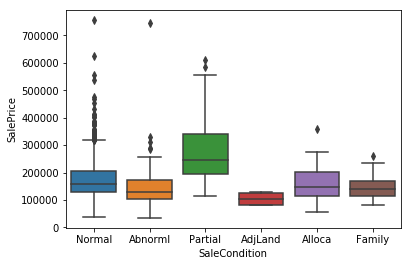

In [25]:
sns.boxplot(df['SaleCondition'], df['SalePrice'])

In [26]:
total_area = df['TotalBsmtSF']+df['1stFlrSF']+df['2ndFlrSF']+df['GarageArea']
+df['WoodDeckSF']+df['OpenPorchSF']+df['EnclosedPorch']+df['3SsnPorch']
+df['ScreenPorch']+df['PoolArea']
lot_usage_rate = df['LotArea']/total_area
lot_usage_rate.describe()

count    1460.000000
mean        3.527470
std         2.539116
min         0.577265
25%         2.554539
50%         3.154980
75%         3.960692
max        45.943436
dtype: float64

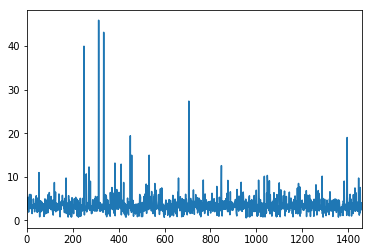

In [27]:
lot_usage_rate.plot()

In [0]:
df['lot_usage_rate']=lot_usage_rate

In [0]:
df['totalSF']=df['TotalBsmtSF']+df['1stFlrSF']+df['2ndFlrSF']

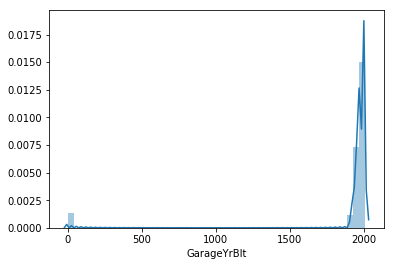

In [30]:
sns.distplot(df['GarageYrBlt'])

In [31]:
df.GarageYrBlt.value_counts().head(5)

0.0       81
2005.0    65
2006.0    59
2004.0    53
2003.0    50
Name: GarageYrBlt, dtype: int64

In [32]:
df['GarageYrBlt'] = df['GarageYrBlt'].replace({0:df['GarageYrBlt'][df['GarageYrBlt'] !=0].mean()})
df.GarageYrBlt.value_counts().head(5)

1978.506164    81
2005.000000    65
2006.000000    59
2004.000000    53
2003.000000    50
Name: GarageYrBlt, dtype: int64

In [0]:
df['has_garage'] = df['GarageArea'] > 0
df['has_woodDeck'] = df['WoodDeckSF'] > 0
df['has_openPorch'] = df['OpenPorchSF'] > 0
df['has_enclosedPorch'] = df['EnclosedPorch'] > 0
df['has_3ssnPorch'] = df['3SsnPorch'] > 0
df['has_screenPorch'] = df['ScreenPorch'] > 0
df['has_pool'] = df['PoolArea'] > 0
df['has_basement'] = df['TotalBsmtSF'] > 0
df['has_lot_frontage'] = df['LotFrontage'] > 0

In [0]:
df[['MSSubClass', 'MSZoning', 'Street', 'Alley',
    'LotShape', 'LandContour', 'Utilities', 'LotConfig',
    'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 
    'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 
    'Exterior1st', 'Exterior2nd', 'MasVnrType',  'Foundation', 'BsmtExposure',
   'BsmtFinType1', 'BsmtFinType2', 'Heating',  
    'CentralAir', 'Electrical', 'Functional', 
   'GarageType', 'GarageFinish',  
     'PavedDrive',  'Fence', 'MiscFeature', 'SaleType', 
    'SaleCondition', 'has_garage', 'has_woodDeck', 'has_openPorch',
   'has_enclosedPorch', 'has_3ssnPorch', 'has_screenPorch', 'has_pool',
   'has_basement', 'has_lot_frontage']] = df[['MSSubClass', 'MSZoning', 
    'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
    'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 
    'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 
    'Exterior1st', 'Exterior2nd', 'MasVnrType',  'Foundation', 'BsmtExposure',
   'BsmtFinType1', 'BsmtFinType2', 'Heating',  
    'CentralAir', 'Electrical', 'Functional', 
   'GarageType', 'GarageFinish',  
     'PavedDrive',  'Fence', 'MiscFeature', 'SaleType', 
    'SaleCondition', 'has_garage', 'has_woodDeck', 'has_openPorch',
   'has_enclosedPorch', 'has_3ssnPorch', 'has_screenPorch', 'has_pool',
   'has_basement', 'has_lot_frontage']].apply(pd.Categorical)

df['ExterQual'] = pd.Categorical(df['ExterQual'], ordered=True, categories=['Fa','TA','Gd','Ex'])
df['ExterCond'] = pd.Categorical(df['ExterCond'], ordered=True, categories=['Po','Fa','TA','Gd','Ex'])
df['BsmtQual'] = pd.Categorical(df['BsmtQual'], ordered=True, categories=['No basement','Fa','TA','Gd','Ex'])
df['BsmtCond'] = pd.Categorical(df['BsmtCond'], ordered=True, categories=['No basement','Po','Fa','TA','Gd'])
df['HeatingQC'] = pd.Categorical(df['HeatingQC'], ordered=True, categories=['Po','Fa','TA','Gd','Ex'])
df['KitchenQual'] = pd.Categorical(df['KitchenQual'], ordered=True, categories=['Fa','TA','Gd','Ex'])
df['FireplaceQu'] = pd.Categorical(df['FireplaceQu'], ordered=True, categories=['No fireplace','Po','Fa','TA','Gd','Ex'])
df['GarageQual'] = pd.Categorical(df['GarageQual'], ordered=True, categories=['No garage','Po','Fa','TA','Gd','Ex'])
df['GarageCond'] = pd.Categorical(df['GarageCond'], ordered=True, categories=['No garage','Po','Fa','TA','Gd','Ex'])
df['PoolQC'] = pd.Categorical(df['PoolQC'], ordered=True, categories=['No pool','Fa','Gd','Ex'])


In [35]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

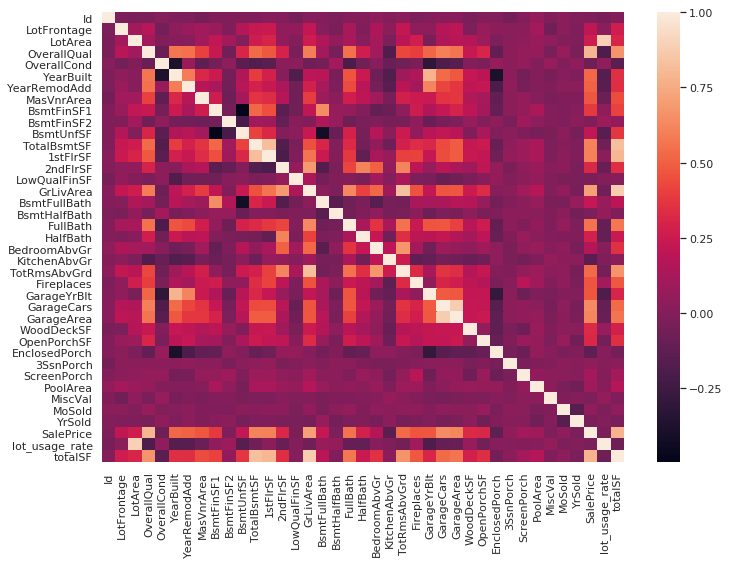

In [36]:
corr = df.corr()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

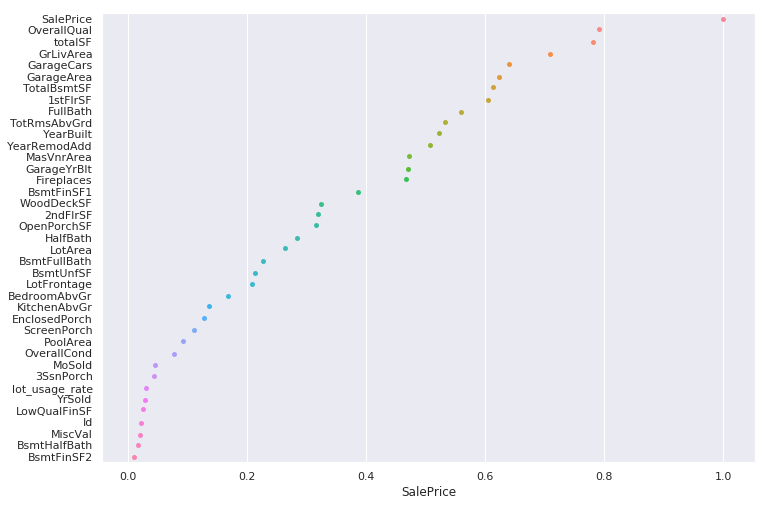

In [37]:
sorted_corrs = df.corr()['SalePrice'].apply(np.abs).sort_values(ascending=False)
sns.stripplot(sorted_corrs, sorted_corrs.index, orient='h')

OverallQual, totalSF, GrLivArea

###Decision tree

In [0]:
from sklearn.tree import DecisionTreeRegressor
ames_X=df[['OverallQual', 'totalSF', 'GrLivArea']]
ames_y=df['SalePrice']

In [39]:
tree = DecisionTreeRegressor()
tree.fit(ames_X,ames_y)
print('R^2',tree.score(ames_X,ames_y))

R^2 0.9965792591794982


## Part 2 / Stretch: "Play Tennis" Classification

We'll reproduce the "Play Tennis" example from Ross Quinlan's 1986 paper, [Induction of Decison Trees](https://link.springer.com/content/pdf/10.1007%2FBF00116251.pdf).

[According to Wikipedia](https://en.wikipedia.org/wiki/Ross_Quinlan), "John Ross Quinlan is a computer science researcher in data mining and decision theory. He has contributed extensively to the development of decision tree algorithms, including inventing the canonical C4.5 and ID3 algorithms."

#### "Table 1 shows a small training set"

In [40]:
import pandas as pd

columns = 'No. Outlook Temperature Humidity Windy PlayTennis'.split()

raw = """1 sunny hot high false N
2 sunny hot high true N
3 overcast hot high false P
4 rain mild high false P
5 rain cool normal false P
6 rain cool normal true N
7 overcast cool normal true P
8 sunny mild high false N
9 sunny cool normal false P
10 rain mild normal false P
11 sunny mild normal true P
12 overcast mild high true P
13 overcast hot normal false P
14 rain mild high true N"""

data = [row.split() for row in raw.split('\n')]
tennis = pd.DataFrame(data=data, columns=columns).set_index('No.')
tennis['PlayTennis'] = (tennis['PlayTennis'] == 'P').astype(int)

tennis

,Outlook,Temperature,Humidity,Windy,PlayTennis
No.,,,,,
1,sunny,hot,high,false,0
2,sunny,hot,high,true,0
3,overcast,hot,high,false,1
4,rain,mild,high,false,1
5,rain,cool,normal,false,1
6,rain,cool,normal,true,0
7,overcast,cool,normal,true,1
8,sunny,mild,high,false,0
9,sunny,cool,normal,false,1


#### "A decision tree that correctly classifies each object in the training set is given in Figure 2."

<img src="https://i.imgur.com/RD7d0u0.png" height="300">

In this dataset, the tennis player decided to play on 64% of the days, and decided not to on 36% of the days.

In [41]:
tennis['PlayTennis'].value_counts(normalize=True) * 100

1    64.285714
0    35.714286
Name: PlayTennis, dtype: float64

The tennis player played on 100% of the overcast days, 40% of the sunny days, and 60% of the  rainy days

In [42]:
tennis.groupby('Outlook')['PlayTennis'].mean() * 100

Outlook
overcast    100.0
rain         60.0
sunny        40.0
Name: PlayTennis, dtype: float64

On sunny days, the tennis player's decision depends on the humidity. (The Outlook and Humidity features interact.)

In [43]:
sunny = tennis[tennis['Outlook']=='sunny']
sunny.groupby('Humidity')['PlayTennis'].mean() * 100

Humidity
high        0
normal    100
Name: PlayTennis, dtype: int64

On rainy days, the tennis player's decision depends on the wind. (The Outlook and Windy features interact.)

In [44]:
rainy = tennis[tennis['Outlook']=='rain']
rainy.groupby('Windy')['PlayTennis'].mean() * 100

Windy
false    100
true       0
Name: PlayTennis, dtype: int64

#### Before modeling, we will ["encode" categorical variables, using pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html?highlight=get_dummies#computing-indicator-dummy-variables)

In [45]:
y = tennis['PlayTennis']
X = pd.get_dummies(tennis.drop(columns='PlayTennis'))
X

,Outlook_overcast,Outlook_rain,Outlook_sunny,Temperature_cool,Temperature_hot,Temperature_mild,Humidity_high,Humidity_normal,Windy_false,Windy_true
No.,,,,,,,,,,
1,0,0,1,0,1,0,1,0,1,0
2,0,0,1,0,1,0,1,0,0,1
3,1,0,0,0,1,0,1,0,1,0
4,0,1,0,0,0,1,1,0,1,0
5,0,1,0,1,0,0,0,1,1,0
6,0,1,0,1,0,0,0,1,0,1
7,1,0,0,1,0,0,0,1,0,1
8,0,0,1,0,0,1,1,0,1,0
9,0,0,1,1,0,0,0,1,1,0


## Train a Decision Tree Classifier
Get a score of 100% (accuracy)

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [46]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X,y)
print('accuracy',tree.score(X,y))

accuracy 1.0


## Compare to Logistic Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [47]:
from sklearn.linear_model import LogisticRegression
import numpy as np

model=LogisticRegression()
model.fit(X,y)
print('r^2',model.score(X,y))

r^2 0.8571428571428571


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Visualize the tree
https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

In [48]:
!pip install dtreeviz
from dtreeviz.trees import dtreeviz


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


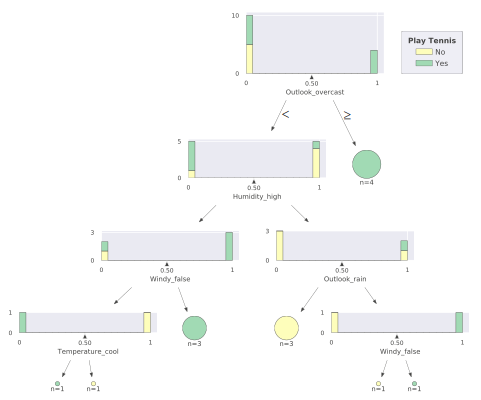

In [49]:
dtreeviz(tree, X, y, 
         target_name='Play Tennis',
         feature_names=X.columns, 
         class_names=['No', 'Yes'])